In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import Levenshtein as lev

import matplotlib.pyplot as plt
from arion.utils import generate_db, peakset2ppm, Colors

In [3]:
data_dir = '/media/shared/arion_data/metabolites'

In [4]:
filled = pd.read_csv('filled.csv').iloc[:, 1:]
features = pd.read_csv('features.csv').iloc[:, 1:]
features.shape

(16, 547)

In [5]:
corr_mat = features.corr('spearman')
top_vals = corr_mat > 0.75

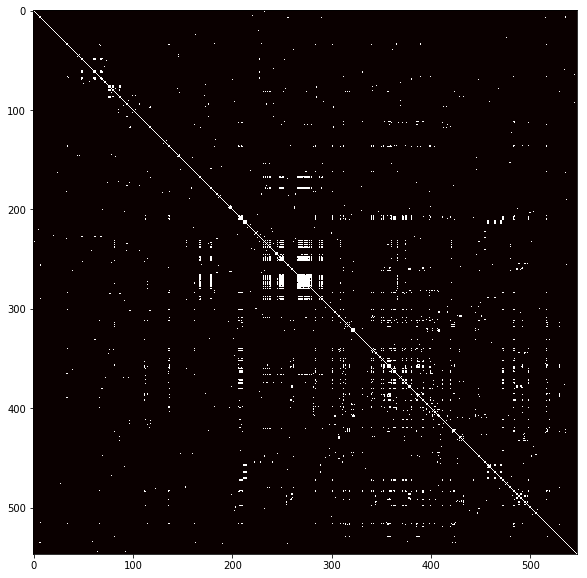

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(top_vals, cmap='hot', interpolation='none')

In [11]:
g = nx.Graph(corr_mat > 0.8)

In [12]:
cliqs = []

MAXCLIQUES = 100000
for idx, cliq in enumerate(nx.find_cliques(g)):
    if idx > MAXCLIQUES:
        raise Exception(f"More than {MAXCLIQUES} cliques found")
        break
    cliqs.append(cliq)
print(f"found {len(cliqs)} cliques")

found 503 cliques


In [13]:
peak_db = generate_db(data_dir)

found 9028 peaks across 615 metabolites


In [14]:
found = False
identified_metabolites = []
for idx, cliq in enumerate(cliqs):
    res = peak_db.query_n(peakset2ppm(cliq, filled))
    for qs in res:
        if qs['score'] >= 0.1 and len(peak_db.metabolite_peaks[qs['metabolite_id']]) > 1 and len(qs['missing']) < 2:
            identified_metabolites.append((idx, cliq, qs))

In [ ]:
identified_m

In [15]:
import glob
import xml.etree.ElementTree as ET

data_dir = '/media/shared/arion_data/metabolites'
xml_file = 'simulation_1/spin_simulation.xml'
cutoff = 0.001

peaks = []
met_idx = 0
names = {}
for met_idx, d in enumerate(glob.glob(f'{data_dir}/bmse*')):
    metabolite_id = d.split('/')[-1]

    tree = ET.parse(f'{d}/{xml_file}')
    root = tree.getroot()
    names[root.find('ID').text] = root.find('name').text

In [16]:
import csv

hamid_met_names = []
with open("names_from_hamid.csv") as f:
    csvfile = csv.reader(f)
    next(csvfile)
    for line in csvfile:
        hamid_met_names.append([l.strip() for l in line])

In [17]:
matched_count = 0
unmatched_count = 0

# unmatched_file = open('umatched.csv', 'w')
# writer = csv.writer(unmatched_file)
# writer.writerow([f"Name {i}" for i in range(1, 6)] + [f"suggestion {i}" for i in range(1, 6)])

matched_set = set()
for hamid_met_name_set in hamid_met_names:
    matches = []
    for n in hamid_met_name_set:
        scores = [(n, lev.jaro(n.lower(), m.lower()), (i, m)) for i, m in names.items()]
        matches.append(max(scores, key=lambda a: a[1]))
    
    if any([abs(m[1] - 1) < 0.000001 for m in matches]):
        matched_count += 1
        maxv = max(matches, key=lambda a: a[1])
#         print(maxv)
        matched_set.add(maxv[2][0])
    else:
        orig = [i[0] for i in matches]
        suggestions = [f'{i[2][1]} <{i[2][0]}>' for i in matches]
        
#         writer.writerow(orig + suggestions)
        
        unmatched_count += 1
print(f"matched {matched_count} | unmatched {unmatched_count}")

matched_set.update(['bmse000208', 'bmse000161', 'bmse000373', 'bmse000092', 'bmse000142', 'bmse000182'])
# unmatched_file.close()

matched 68 | unmatched 46


In [18]:
unique_metabolites = {i[2]['metabolite_id'] for i in identified_metabolites}
print(f'identified {len(unique_metabolites)} potential metabolites')
matched_cnt = 0
for m in unique_metabolites:
    if m in matched_set:
        matched_cnt += 1
        print(f"{m}({len(peak_db.metabolite_peaks[m])})", Colors.color(f"found - {names[m]}", Colors.OKGREEN) if m in matched_set else Colors.color("not found", Colors.FAIL))
print(matched_cnt)

identified 164 potential metabolites
bmse000076(4) found - Citrate
bmse000373(13) found - Isovaleric-acid
bmse000297(7) found - Ethanol
bmse000208(6) found - L-(+) Lactic acid
bmse000285(9) found - Choline
bmse000069(2) found - Betaine
bmse000300(8) found - Benzoate
bmse000041(48) found - L-Isoleucine
bmse000132(10) found - Homovanillic acid
bmse000439(9) found - Isobutyric acid
bmse000044(21) found - L-Methionine
bmse000424(8) found - Adipic acid
bmse000398(6) found - Methylmalonic acid
bmse000220(7) found - Phenylacetic acid
bmse000161(16) found - 3-Hydroxybutyrate
bmse000614(6) found - Vanillic acid
bmse000863(7) found - Taurine
bmse000160(2) found - Sarcosine
bmse000458(5) found - P-Cresol
bmse000064(8) found - Alpha-Ketoglutaric acid
bmse000339(8) found - 3-Hydroxyphenylacetic acid
bmse000078(4) found - Creatine
bmse000049(10) found - L-Threonine
bmse000206(4) found - Caffeine
bmse000159(6) found - Beta-Alanine
bmse000155(2) found - Creatinine
26


## Playground

In [23]:
filled[np.logical_and(filled.peakPPM > 3.09, filled.peakPPM < 3.10)]

,peakIndex,peakPPM,peakValue,peakSNR,peakScale,Sample
2932,39724,3.09768,1645.851751,78.810757,16.0,1
2933,39724,3.09768,1668.194836,16.073119,16.0,2
2934,39724,3.09768,1353.187492,27.515097,16.0,4
2935,39724,3.09768,1442.829691,21.724018,16.0,5
2936,39724,3.09792,799.588237,13.440489,16.0,6
2937,39724,3.09768,1048.566347,25.428368,16.0,7
2938,39724,3.09792,1099.928058,41.239464,15.0,8
2939,39724,3.09792,2318.607778,36.745645,16.0,9
2940,39724,3.09792,1144.814369,29.424182,16.0,10
2941,39724,3.09792,1526.418191,25.952690,16.0,11
